In [1]:
import sys
import numpy as np
import time
from tqdm.notebook import tqdm as tqdm
import random
from math import log2
from heapq import heapify, heappop, heappush, heapreplace, nlargest, nsmallest

## Neighborhood Construction Procedures

In [2]:
# TODO раскопать историю разработки данной эвристики. Найти авторов из 80х, кто первый предложил её
# пока предполагаем, что в candidates передаётся только список индексов
# Method expects that candidates is a list of tuples [(c_1,dist_1), (c_2, dist_2), ...,  ]
# Returns the sublist of candidates.
def heuristic(candidates, curr, k, distance_func, data):
    candidates = sorted(candidates, key=lambda a: a[1])
    result_indx_set = {candidates[0][0]}
    result = [candidates[0]]
    added_data = [ data[candidates[0][0]] ]
    for c, curr_dist in candidates[1:]:
        c_data = data[c]       
        if curr_dist < min(map(lambda a: distance_func(c_data, a), added_data)):
            result.append( (c, curr_dist))
            result_indx_set.add(c)
            added_data.append(c_data)
    for c, curr_dist in candidates: # optional. uncomment to build neighborhood exactly with k elements.
        if len(result) < k and (c not in result_indx_set):
            result.append( (c, curr_dist) )
    
    return result
def k_closest(candidates: list, curr, k, distance_func, data):
    return sorted(candidates, key=lambda a: a[1])[:k]

# HNSW Implementaion with Plugable Neighborhood Construction Procedure

In [40]:
def l2_distance(a, b):
    return np.linalg.norm(a - b)
    
class HNSW:
    # self._graphs[level][i] contains a {j: dist} dictionary,
    # where j is a neighbor of i and dist is distance

    def _distance(self, x, y):
        return self.distance_func(x, [y])[0]

    def vectorized_distance_(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def __init__(self, distance_func, m=5, ef=10, ef_construction=30, m0=None, neighborhood_construction=heuristic, vectorized=False):
        self.data = []
        self.distance_func = distance_func
        self.neighborhood_construction = neighborhood_construction

        if vectorized:
            self.distance = self._distance
            self.vectorized_distance = distance_func
        else:
            self.distance = distance_func
            self.vectorized_distance = self.vectorized_distance_

        self._m = m
        self._ef = ef
        self._ef_construction = ef_construction
        self._m0 = 2 * m if m0 is None else m0
        self._level_mult = 1 / log2(m)
        self._graphs = []
        self._enter_point = None

    def add(self, elem, ef=None):

        if ef is None:
            ef = self._ef

        distance = self.distance
        data = self.data
        graphs = self._graphs
        point = self._enter_point
        m = self._m

        # level at which the element will be inserted
        level = int(-log2(random.random()) * self._level_mult) + 1
        # print("level: %d" % level)

        # elem will be at data[idx]
        idx = len(data)
        data.append(elem)


        if point is not None:  # the HNSW is not empty, we have an entry point
            dist = distance(elem, data[point])
            # for all levels in which we dont have to insert elem,
            # we search for the closest neighbor
            for layer in reversed(graphs[level:]):
                point, dist = self.beam_search(graph=layer, q=elem, k=1, eps=[point], ef=1)[0]
            # at these levels we have to insert elem; ep is a heap of entry points.

            layer0 = graphs[0]
            for layer in reversed(graphs[:level]):
                level_m = m if layer is not layer0 else self._m0
                # navigate the graph and update ep with the closest
                # nodes we find
                # ep = self._search_graph(elem, ep, layer, ef)
                candidates = self.beam_search(graph=layer, q=elem, k=level_m*2, eps=[point], ef=self._ef_construction)
                point = candidates[0][0]
                
                # insert in g[idx] the best neighbors
                # layer[idx] = layer_idx = {}
                # self._select(layer_idx, ep, level_m, layer, heap=True)

                neighbors = self.neighborhood_construction(candidates=candidates, curr=idx, k=level_m, distance_func=self.distance_func, data=self.data)
                layer[idx] = neighbors
                # insert backlinks to the new node
                for j, dist in neighbors:
                    candidates_j = layer[j] + [(idx, dist)]
                    neighbors_j = self.neighborhood_construction(candidates=candidates_j, curr=j, k=level_m, distance_func=self.distance_func, data=self.data)
                    layer[j] = neighbors_j
                    
                
        for i in range(len(graphs), level):
            # for all new levels, we create an empty graph
            graphs.append({idx: []})
            self._enter_point = idx
            
    # can be used for search after jump        
    def search(self, q, k=1, ef=10, level=0, return_observed=True):
        graphs = self._graphs
        point = self._enter_point
        for layer in reversed(graphs[level:]):
            point, dist = self.beam_search(layer, q=q, k=1, eps=[point], ef=1)[0]

        return self.beam_search(graph=graphs[level], q=q, k=k, eps=[point], ef=ef, return_observed=return_observed)

    def beam_search(self, graph, q, k, eps, ef, ax=None, marker_size=20, return_observed=False):
        '''
        graph – the layer where the search is performed
        q - query
        k - number of closest neighbors to return
        eps – entry points [vertex_id, ..., vertex_id]
        ef – size of the beam
        observed – if True returns the full of elements for which the distance were calculated
        returns – a list of tuples [(vertex_id, distance), ... , ]
        '''
        # Priority queue: (negative distance, vertex_id)
        candidates = []
        visited = set()  # set of vertex used for extending the set of candidates
        observed = dict() # dict: vertex_id -> float – set of vertexes for which the distance were calculated

        if ax:
            ax.scatter(x=q[0], y=q[1], s=marker_size, color='red', marker='^')
            ax.annotate('query', (q[0], q[1]))

        # Initialize the queue with the entry points
        for ep in eps:
            dist = self.distance_func(q, self.data[ep])
            heappush(candidates, (dist, ep))
            observed[ep] = dist

        while candidates:
            # Get the closest vertex (furthest in the max-heap sense)
            dist, current_vertex = heappop(candidates)

            if ax:
                ax.scatter(x=self.data[current_vertex][0], y=self.data[current_vertex][1], s=marker_size, color='red')
                ax.annotate( len(visited), self.data[current_vertex] )

            # check stop conditions #####
            observed_sorted = sorted( observed.items(), key=lambda a: a[1] )
            # print(observed_sorted)
            ef_largets = observed_sorted[ min(len(observed)-1, ef-1 ) ]
            # print(ef_largets[0], '<->', -dist)
            if ef_largets[1] < dist:
                break
            #############################

            # Add current_vertex to visited set
            visited.add(current_vertex)

            # Check the neighbors of the current vertex
            for neighbor, _ in graph[current_vertex]:
                if neighbor not in observed:
                    dist = self.distance_func(q, self.data[neighbor])                    
                    # if neighbor not in visited:
                    heappush(candidates, (dist, neighbor))
                    observed[neighbor] = dist                    
                    if ax:
                        ax.scatter(x=self.data[neighbor][0], y=self.data[neighbor][1], s=marker_size, color='yellow')
                        # ax.annotate(len(visited), (self.data[neighbor][0], self.data[neighbor][1]))
                        ax.annotate(len(visited), self.data[neighbor])
                    
        
        # Sort the results by distance and return top-k
        observed_sorted =sorted( observed.items(), key=lambda a: a[1] )
        if return_observed:
            return observed_sorted
        return observed_sorted[:k]
    def save_graph_plane(self, file_path):
        with open(file_path, "w") as f:
            f.write(f'{len(self.data)}\n')

            for x in self.data:
                s = ' '.join([a.astype('str') for a in x ])
                f.write(f'{s}\n')

            for graph in self._graphs:
                for src, neighborhood in graph.items():
                    for dst, dist in neighborhood: 
                        f.write(f'{src} {dst}\n')

## Preliminaries 

### Generate data

In [41]:
k =5 
dim = 2
n = 1000
data_a = np.array(np.float32(np.random.random((n, dim))))
data_b = np.array(np.float32(np.random.random((n, dim))))
merged_data = np.concatenate((data_a.data, data_b.data), axis=0)

In [42]:
hnsw_a = HNSW( distance_func=l2_distance, m=5, m0=7, ef=10, ef_construction=30,  neighborhood_construction = heuristic)
hnsw_b = HNSW( distance_func=l2_distance, m=5, m0=7, ef=10, ef_construction=30,  neighborhood_construction = heuristic)
for x in tqdm(data_a):
    hnsw_a.add(x)
for x in tqdm(data_b):
    hnsw_b.add(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
# hnsw_a.save_graph_plane('hnsw_a.txt')

## Define recall function

In [6]:
def calculate_recall(hnsw, test, groundtruth=None, k=5, ef=10):
    if groundtruth is None:
        groundtruth = []
        print("Ground truth not found. Calculating ground truth...")
        for query in tqdm(test):
            groundtruth.append([idx for idx, dist in sorted(enumerate( map(lambda a: hnsw.distance_func(query, a), hnsw.data) ), key=lambda a: a[1])[:k]])

    print("Calculating recall...")
    recalls = []
    total_calc = 0
    for query, true_neighbors in tqdm(zip(test, groundtruth), total=len(test)):
        true_neighbors = true_neighbors[:k]  # Use only the top k ground truth neighbors
        observed = [neighbor for neighbor, dist in hnsw.search(q=query, k=k, ef=ef, return_observed = True)]
        total_calc = total_calc + len(observed)
        results = observed[:k]
        intersection = len(set(true_neighbors).intersection(set(results)))
        # print(f'true_neighbors: {true_neighbors}, results: {results}. Intersection: {intersection}')
        recall = intersection / k
        recalls.append(recall)

    return np.mean(recalls), total_calc/len(test)

# Now it is a time to merge 2 HNSW-graphs

## HNSW Merge - General Alg

In [7]:
def hnsw_merge(hnsw_a, hnsw_b, layer_merge_func):
    hnsw_merged = HNSW(hnsw_a.distance_func, m=hnsw_a._m, m0=hnsw_a._m0, ef=hnsw_a._ef, ef_construction=hnsw_a._ef_construction, neighborhood_construction = hnsw_a.neighborhood_construction)
    hnsw_merged.data = hnsw_a.data + hnsw_b.data
    hnsw_merged._graphs = []
    levels_merged = max(len(hnsw_a._graphs), len(hnsw_b._graphs))
    levels_merged_min = min(len(hnsw_a._graphs), len(hnsw_b._graphs))

    if len(hnsw_a._graphs) >= len(hnsw_b._graphs):
        hnsw_merged._enter_point = hnsw_a._enter_point
    else:
        hnsw_merged._enter_point = hnsw_b._enter_point + len(hnsw_a.data)

    for level in range(levels_merged_min): 
        print('Merging level:', level)
        # hnsw_merged._graphs.append(  merge_naive( hnsw_merged.distance_func, hnsw_a, hnsw_b, level, search_ef=20) ) 
        hnsw_merged._graphs.append(  layer_merge_func( hnsw_merged.distance_func, hnsw_a, hnsw_b, level) ) 

    return hnsw_merged

# Algorithm 0 – Naive
Seqensional traversing one graph by one with using regular beam_search <br> 
- Compexity $O(\log(N+M) \cdot (N + M) )$.
- Additional space on disk $O(N + M)$

In [9]:
# merged_edges = [ None for i in range(len(kga.data) + len(kgb.data) ) ]

currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step

# нам нужно два вида поиска:
# jump search – стартуем от одной или нескольких произвольных начальных точек
# local search - мы уже где-то рядом и надо сделать только локальный обход, чтобы набрать кандидатов для формирования окрестности

# Вопрос в том, кто выполняет эти операции. сам hnsw класс, у которого merge-алгоритм знает про эти методы? 
# или эти два метода передаются в алгоритм объединения?

def merge_naive(distance_func, hnsw_a, hnsw_b, level, search_ef=5, M = 5):
    '''
    kga          – first graph 
    kgb          – second graph
    search_ef    - ef parameter for searching candidates in the second grap
    M            – number of starting random enter points
                  
    '''
    merged_edges = {}
    for curr_idx in tqdm(hnsw_a._graphs[level].keys()): 
        currents.append(curr_idx)
        observed = hnsw_b.search(q=hnsw_a.data[curr_idx], k=k, ef=search_ef, level=level, return_observed=True) #return_observed=True
        observed_steps.append([ (idx+len(hnsw_a.data), dist) for idx, dist in observed])
        # candidates_b = observed[:k]
        candidates_b = observed
        # == build neighborhood for curr_idx and save to externalset of edges  ==
        candidates = [ (idx_b + len(hnsw_a.data), dist) for idx_b, dist in candidates_b] + [ (idx, dist) for idx, dist in hnsw_a._graphs[level][curr_idx]]
        # merged_edges[curr_idx] = sorted ([ (idx_b + len(kga.data), dist) for idx_b, dist in candidates_b] + [ (idx, dist) for idx, dist in kga.edges[curr_idx]], key=lambda a: a[1])[:k]
        merged_edges[curr_idx] = hnsw_a.neighborhood_construction(candidates, hnsw_a.data[curr_idx], k, distance_func, merged_data)    
        # == == == == == == == == == == == == == == == == == == == == == == == ==

    for curr_idx in tqdm(hnsw_b._graphs[level].keys()): 
        currents.append(curr_idx + len(hnsw_a.data))
        observed = hnsw_a.search(q=hnsw_b.data[curr_idx], k=k, ef=search_ef, level=level, return_observed=True)
        observed_steps.append([ (idx, dist) for idx, dist in observed])
        # candidates_a = observed[:k]
        candidates_a = observed
        # == build neighborhood for curr_idx and save to externalset of edges  ==
        candidates = [(idx_a, dist) for idx_a, dist in candidates_a] + [(idx + len(hnsw_a.data), dist) for idx, dist in hnsw_b._graphs[level][curr_idx]]
        merged_edges[curr_idx + len(hnsw_a.data)] = hnsw_b.neighborhood_construction(candidates, hnsw_b.data[curr_idx], k, distance_func, merged_data)
        # == == == == == == == == == == == == == == == == == == == == == == == ==

    return merged_edges

def layer_merge0_func(distance_func, hnsw_a, hnsw_b, level) :
  return merge_naive(distance_func, hnsw_a, hnsw_b, level, search_ef=20)

hnsw_merged = hnsw_merge(hnsw_a, hnsw_b, layer_merge0_func)

print('Total metric calculation:', sum([len(steps) for steps in observed_steps ]))
print('Merging accuracy', calculate_recall(hnsw_merged, hnsw_b.data, k=5, ef=1))
# print('Merging accuracy', merging_accuracy(merged_data, merged_edges))

Merging level: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Merging level: 1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Merging level: 2


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Merging level: 3


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Total metric calculation: 12530
Ground truth not found. Calculating ground truth...


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating recall...


  0%|          | 0/1000 [00:00<?, ?it/s]

Merging accuracy (np.float64(0.9710000000000001), 5.0)


# Algorithm 1
Seqensional traversing one graph by one <br> 
- Version with no filter-beam-search
- Compexity O(N + M). Additional space on disk O(N + M)

In [10]:
currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step
jumps = []

def merge1(hnsw_a, hnsw_b, inverse_flag, level, jump_ef=1, local_ef=5, next_step_k=1, next_step_ef=5, M = 5):
    '''
    kga          – first graph 
    kgb          – second graph
    inverse_flat – True if graphs are passed in inverse order
    search_ef    - ef parameter for searching candidates in the second graph
    next_step_k  - at each iteration we look for the next element around the current vertex in the first graph. 
                   However it can be surrounded by the "done" vertex, so we have to walk away. 
                   Thus this parameter controlls how far from the current vertex we can go.
    next_step_ef – a purpose of this parameter is similar {next_step_k}
    M            – number of point returned by the jump-search                 
    '''
    merged_edges = {}
    not_done = set( hnsw_a._graphs[level].keys() )
    

    # TODO: replace by mapping function
    shift = len(hnsw_a.data)
    reverse_shift = 0
    if inverse_flag:
        shift = 0
        # reverse_shift = len(hnsw_b.data)
        reverse_shift = len(hnsw_b.data)

    
        
    while not_done:
        curr_idx = not_done.pop()
        jumps.append(curr_idx)
        # perform junp jump search 
        observed = hnsw_b.search(q=hnsw_a.data[curr_idx], k=M, ef=jump_ef, level=level, return_observed=True) #return_observed=True
        staring_points = [idx for idx, dist in observed[:M]]
        
        while True:
            currents.append(curr_idx + reverse_shift)
            # perform local search at graph B
            observed.extend(hnsw_b.beam_search(graph=hnsw_b._graphs[level], q=hnsw_a.data[curr_idx], k=k, eps=staring_points, ef=local_ef, return_observed=True))
            # print(observed)           
            # observed_steps.append(observed)
            observed_steps.append([ (idx + shift, dist) for idx, dist in observed])
            candidates_b = observed[:k]
            # candidates_b = observed
            # == build neighborhood for curr_idx and save to externalset of edges  ==            
            candidates  = [ (idx_b + shift, dist) for idx_b, dist in candidates_b] + [ (idx + reverse_shift, dist) for idx, dist in hnsw_a._graphs[level][curr_idx]]
            merged_edges[curr_idx + reverse_shift] = hnsw_a.neighborhood_construction(candidates, merged_data[curr_idx + reverse_shift], k, hnsw_a.distance_func, merged_data)                
            # == == == == == == == == == == == == == == == == == == == == == == == ==
    
            staring_points_points = [idx for idx, dist in candidates_b[:k]] # ! determine a new set of enter_points for search on kgb

            # do local serach at graph A
            candidates_a = hnsw_a.beam_search(graph=hnsw_a._graphs[level],q=hnsw_a.data[curr_idx], k=next_step_k, eps=[ curr_idx], ef=next_step_ef, return_observed=True) # decrease k to traverse closer to curr vertex
            observed_steps[-1].extend([ (idx+reverse_shift, dist) for idx, dist in candidates_a])
            candidates_a = [c[0] for c in candidates_a[:next_step_k] if c[0] in not_done]
    
            if not candidates_a:
                break
            curr_idx = candidates_a[0]
            not_done.remove(curr_idx)
            observed = []
    return merged_edges

def layer_merge1_func(distance_func, hnsw_a, hnsw_b, level) :
    merged_edges = {} 
    # phase 1) 
    merged_edges.update(merge1(hnsw_a, hnsw_b, inverse_flag=False, level=level, jump_ef=20, local_ef=5, next_step_k=5, next_step_ef=3, M = 5))
    # phase 2)
    merged_edges.update(merge1(hnsw_b, hnsw_a, inverse_flag=True,  level=level, jump_ef=20, local_ef=5, next_step_k=5, next_step_ef=3, M = 5))
    return merged_edges

hnsw_merged = hnsw_merge(hnsw_a, hnsw_b, layer_merge1_func)

print('Number of jumps:', len(jumps) ) 
print('Total metric calculation:', sum([len(steps) for steps in observed_steps ]))
# print('Merging accuracy', merging_accuracy(merged_data, merged_edges))
print('Merging accuracy', calculate_recall(hnsw_merged, hnsw_b.data, k=5, ef=1))

Merging level: 0
Merging level: 1
Merging level: 2
Merging level: 3
Number of jumps: 398
Total metric calculation: 80425
Ground truth not found. Calculating ground truth...


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating recall...


  0%|          | 0/1000 [00:00<?, ?it/s]

Merging accuracy (np.float64(0.9710000000000001), 5.0)


## Visualisation - Alg1

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

# scat = ax.scatter(kga.data[:, 0], kga.data[:, 1], c='blue')
def update(frame):    
    ax.clear()
    # kga.plot_graph(ax, color='blue', linewidth=0.2)
    
    not_done = set(range(len(merged_data)))
    for i in range(frame):
        not_done.remove(currents[i])
    
    colors = ['blue' if i in not_done else 'black' for i in range(len(kga.data))]
    colors = colors + ['green' if i in not_done else 'black' for i in range(len(kga.data),len(merged_data))]
    
    # kga.plot_graph(ax, color='blue', linewidth=0.2)    
    ax.scatter(merged_data[:, 0], merged_data[:, 1], c=colors)

    for vertex_id, dist in observed_steps[frame]:
        ax.scatter(merged_data[vertex_id][0], merged_data[vertex_id][1], c='yellow')
    
    for i in range(frame):
        for edge_end, dist in merged_edges[currents[i]]:
            ax.plot( [merged_data[currents[i]][0], merged_data[edge_end][0]], [merged_data[currents[i]][1], merged_data[edge_end][1]], c= 'blue' if edge_end < len(kga.data) else 'green' )
        
    return fig, ax
ani = FuncAnimation(fig, update, frames=tqdm(range(len(merged_data))))
ani.save(f"gifs/merging-alg1h-n{n}k{}.gif", fps=10)

![Algorithm1](gifs/merging-alg1h-n100k7.gif "Merging Graphs - Algorithm 1")

# Algorithm 2
Traversing over two graphs<br>
- Version with no filter-beam-search
- Complexity $\theta (n+m)$ 

In [12]:
# import random
# merged_data = np.concatenate((kga.data, kgb.data), axis=0)

currents = [] # sequence of steps for visualisation
observed_steps = [] # the of elements for which the distance were calculated on a particular step
jumps = []

def merge_alg2(hnsw_a, hnsw_b, level, jump_ef = 20, local_ef=5, next_step_k=3, M = 3):
    '''
    hnsw_a       – first graph 
    hnsw_b       – second graph
    search_ef    - ef parameter for searching candidates in the second graph
    next_step_k  - at each iteration we look for the next element around the current vertex in the first graph. 
                   However it can be surrounded by the "done" vertex, so we have to walk away. 
                   Thus this parameter controlls how far from the current vertex we can go.
    M            – number of starting random enter points                 
    '''
    merged_edges = {}
    merged_data =  np.concatenate((hnsw_a.data, hnsw_b.data), axis=0)
    
    not_done_a = set( hnsw_a._graphs[level].keys())
    not_done_b = set( hnsw_b._graphs[level].keys())
    # not_done = not_done_a.union(not_done_b)
    not_done = not_done_a.union( [i + len(hnsw_a.data) for i in not_done_b] )
    
    while not_done:
        curr_idx = random.choice(list(not_done))
        # not_done.remove(curr_idx) # remove from not_done
        jumps.append(curr_idx)
    
        # do jump search   
        observed_jump_a = hnsw_a.search(q=merged_data[curr_idx], k=M, ef=jump_ef, level=level, return_observed=True) #return_observed=True
        observed_jump_b = hnsw_b.search(q=merged_data[curr_idx], k=M, ef=jump_ef, level=level, return_observed=True) #return_observed=True

        enter_points_a = [idx for idx, dist in observed_jump_a[:M]]
        enter_points_b = [idx for idx, dist in observed_jump_b[:M]]
        while True:
            currents.append(curr_idx)
            not_done.remove(curr_idx) # remove from not_done
            # print('curr_idx:', curr_idx)

            # searching for a new current
            # observed_a = kga.beam_search(merged_data[curr_idx], k, eps=enter_points_a, ef=ef, return_observed=True)

            # do local serach at graph A. # decrease k to traverse closer to curr vertex
            observed_a = hnsw_a.beam_search(graph=hnsw_a._graphs[level], q=merged_data[curr_idx], k=k, eps=enter_points_a, ef=local_ef, return_observed=True) 
            # do local serach at graph A. # decrease k to traverse closer to curr vertex
            observed_b = hnsw_b.beam_search(graph=hnsw_b._graphs[level], q=merged_data[curr_idx], k=k, eps=enter_points_b, ef=local_ef, return_observed=True)
            
            observed_steps.append(observed_a + observed_jump_a + [ (idx + len(hnsw_a.data), dist) for idx, dist in observed_b + observed_jump_b ])
            
            candidates_a = observed_a[:k]
            candidates_b = observed_b[:k]

            # == build neighborhood for new_curr_idx and save to externalset of edges  ==
            if curr_idx < len(hnsw_a.data):
                # merged_edges[curr_idx] = sorted (kga.edges[curr_idx] + [ (idx_b + len(kga.data), dist) for idx_b, dist in candidates_b], key=lambda a: a[1])[:k]
                candidates  = hnsw_a._graphs[level][curr_idx] + [ (idx_b + len(hnsw_a.data), dist) for idx_b, dist in candidates_b]
            else:
                # merged_edges[curr_idx] = sorted (candidates_a + [(idx_b + len(kga.data), dist) for idx_b, dist in kgb.edges[curr_idx - len(kga.data)]], key=lambda a: a[1])[:k]
                candidates =  candidates_a + [(idx_b + len(hnsw_a.data), dist) for idx_b, dist in hnsw_b._graphs[level][curr_idx - len(hnsw_a.data)]]
            
            # merged_edges[curr_idx] = kga.neigborhood_construction(candidates, merged_data[curr_idx], k, kga.distance_func, merged_data)                           
            merged_edges[curr_idx] = hnsw_a.neighborhood_construction(candidates, merged_data[curr_idx], k, hnsw_a.distance_func, merged_data)                
            # =============================================================================================================================
                  
            candidates_a_not_done = [ (idx, dist) for idx, dist in observed_a if idx in not_done]
            candidates_b_not_done = [ (idx + len(hnsw_a.data), dist) for idx, dist in observed_b if idx + len(hnsw_a.data) in not_done]
            
            candidates_not_done = [candidates_a_not_done[0]] if len(candidates_a_not_done) > 0 else [] + [candidates_b_not_done[0]] if len(candidates_b_not_done) > 0 else []

            if not candidates_not_done: 
                break #jump to the random point

            new_curr = min(candidates_not_done, key=lambda a: a[1])
            new_curr_idx = new_curr[0]
                        
            curr_idx = new_curr_idx
            enter_points_a = [idx for idx, dist in candidates_a]
            enter_points_b = [idx for idx, dist in candidates_b]
            # ef = search_ef
            observed_jump_a = []
            observed_jump_b = []
    return merged_edges
                           
# merge_alg2(kga, kgb, jump_ef=20, search_ef=5, next_step_k=5, M = 5)


def layer_merge2_func(distance_func, hnsw_a, hnsw_b, level) :
    return merge_alg2(hnsw_a=hnsw_a, hnsw_b=hnsw_b, level=level, jump_ef=20, local_ef=5, next_step_k=5, M = 5)

hnsw_merged = hnsw_merge(hnsw_a, hnsw_b, layer_merge2_func)

print('Number of jumps:', len(jumps) ) 
print('Total metric calculation:', sum([len(steps) for steps in observed_steps ]))

print('Merging accuracy', calculate_recall(hnsw_merged, hnsw_b.data, k=5, ef=1))
# print('Merging accuracy', merging_accuracy(merged_data, merged_edges))

Merging level: 0
Merging level: 1
Merging level: 2
Merging level: 3
Number of jumps: 55
Total metric calculation: 78162
Ground truth not found. Calculating ground truth...


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating recall...


  0%|          | 0/1000 [00:00<?, ?it/s]

Merging accuracy (np.float64(0.9710000000000001), 5.0)


## Visualisation - ALG2

  0%|          | 0/1000 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


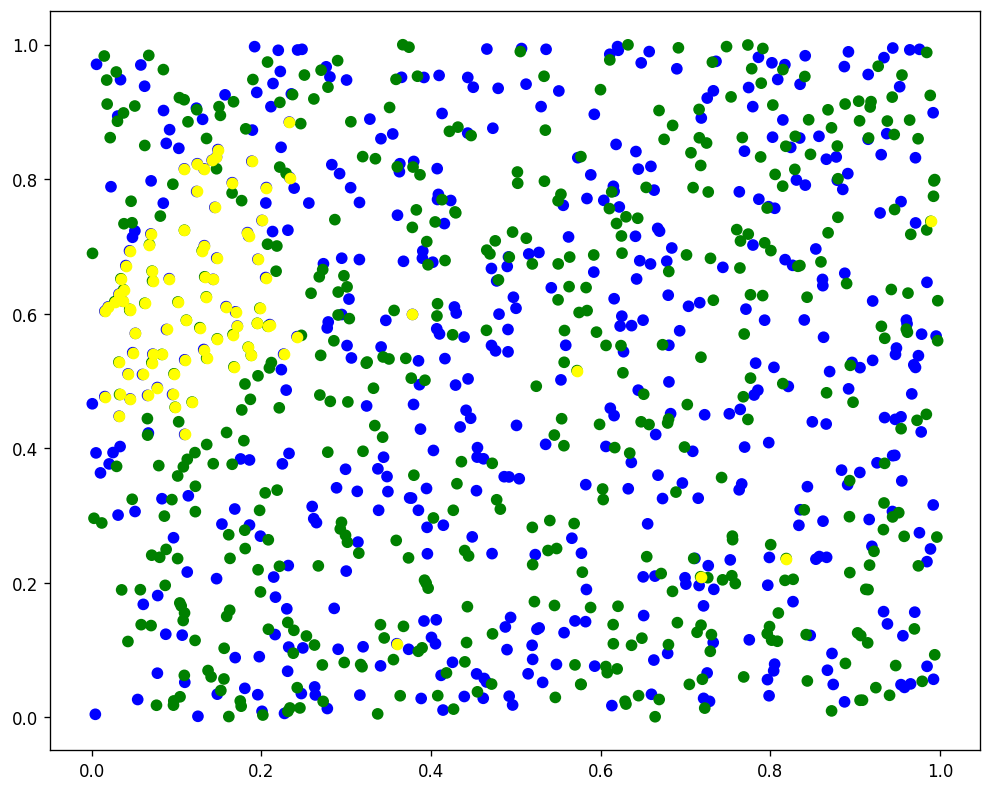

In [86]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

# scat = ax.scatter(kga.data[:, 0], kga.data[:, 1], c='blue')
def update(frame):    
    ax.clear()
    # kga.plot_graph(ax, color='blue', linewidth=0.2)
    
    not_done = set(range(len(merged_data)))
    for i in range(frame):
        not_done.remove(currents[i])
    
    colors = ['blue' if i in not_done else 'black' for i in range(len(kga.data))]
    colors = colors + ['green' if i in not_done else 'black' for i in range(len(kga.data),len(merged_data))]
    
    for curr_idx in currents[:frame]:
        colors[curr_idx] = 'red' 
    
    # kga.plot_graph(ax, color='blue', linewidth=0.2)    
    ax.scatter(merged_data[:, 0], merged_data[:, 1], c=colors)

    for vertex_id, dist in observed_steps[frame]:
        ax.scatter(merged_data[vertex_id][0], merged_data[vertex_id][1], c='yellow')
    
    for i in range(frame):
        for edge_end, dist in merged_edges[currents[i]]:
            ax.plot( [merged_data[currents[i]][0], merged_data[edge_end][0]], [merged_data[currents[i]][1], merged_data[edge_end][1]], c= 'blue' if edge_end < len(kga.data) else 'green' )
        
    return fig, ax
ani = FuncAnimation(fig, update, frames=tqdm(range(len(merged_data))))
ani.save(f"gifs/merging-alg2-n-{n}.gif", fps=10)